In [ ]:
from google.colab import drive
drive.mount('/content/drive')

src = '/content/drive/MyDrive/Colab Notebooks/zey akbank proje/kaggle.json'

import os
os.makedirs('/root/.kaggle', exist_ok=True)

# kopyala + izinleri ayarla
!cp "{src}" /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
!ls -l /root/.kaggle


Mounted at /content/drive
total 4
-rw------- 1 root root 65 Sep 24 13:11 kaggle.json


In [ ]:
!pip -q install kaggle
!kaggle datasets download -d puneet6060/intel-image-classification -p /content -q
!unzip -q /content/intel-image-classification.zip -d /content/intel_intake


Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors


In [ ]:
import os, numpy as np, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def descend_if_single_wrapper(p, wrappers=("seg_train","Seg_train","train","seg_test","Seg_test","test")):
    """ Eğer p altında sadece 1 klasör varsa ve adı 'seg_train/seg_test/train/test' ise, bir seviye daha derine in. """
    if p is None:
        return None
    entries = [d for d in os.listdir(p) if os.path.isdir(os.path.join(p, d))]
    if len(entries) == 1 and entries[0] in wrappers:
        return os.path.join(p, entries[0])
    return p

In [ ]:
# === RECOVERY CELL: TRAIN_DIR / TEST_DIR'yi yeniden kur ===
import os, zipfile

# 1) Yardımcılar
def find_subdir(root, candidates=("seg_train","Seg_train","train")):
    for dirpath, dirnames, filenames in os.walk(root):
        if os.path.basename(dirpath) in candidates:
            return dirpath
    return None

def descend_if_single_wrapper(p, wrappers=("seg_train","Seg_train","train","seg_test","Seg_test","test")):
    if p is None:
        return None
    entries = [d for d in os.listdir(p) if os.path.isdir(os.path.join(p, d))]
    if len(entries) == 1 and entries[0] in wrappers:
        return os.path.join(p, entries[0])
    return p

# 2) İçeriği nerede arayalım?
extract_dir = "/content/intel_intake"
zip_path    = "/content/intel-image-classification.zip"

# Eğer extract_dir yoksa ve zip varsa → tekrar aç
if not os.path.exists(extract_dir):
    if os.path.exists(zip_path):
        os.makedirs(extract_dir, exist_ok=True)
        with zipfile.ZipFile(zip_path, 'r') as z:
            z.extractall(extract_dir)
    else:
        raise FileNotFoundError(
            "Dataset klasörü ve zip bulunamadı. "
            "Önce indirme hücresini çalıştırın:\n"
            "!pip -q install kaggle\n"
            "!kaggle datasets download -d puneet6060/intel-image-classification -p /content -q\n"
            "!unzip -q /content/intel-image-classification.zip -d /content/intel_intake"
        )

# 3) Yol bulma (çift katman problemine dayanıklı)
_raw_train = find_subdir(extract_dir, ("seg_train","Seg_train","train"))
_raw_test  = find_subdir(extract_dir, ("seg_test","Seg_test","test"))
TRAIN_DIR  = descend_if_single_wrapper(_raw_train)
TEST_DIR   = descend_if_single_wrapper(_raw_test)

# 4) Kontrol ve çıktı
if not (TRAIN_DIR and TEST_DIR):
    print("Klasör yapısı beklenenden farklı. Mevcut dizinler:")
    for p, d, f in os.walk(extract_dir):
        print(p)
    raise FileNotFoundError("seg_train/seg_test klasörleri bulunamadı.")

print("✅ TRAIN_DIR:", TRAIN_DIR)
print("✅ TEST_DIR :", TEST_DIR)
print("✅ Train sınıf klasörleri:", [d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR,d))])


✅ TRAIN_DIR: /content/intel_intake/seg_train/seg_train
✅ TEST_DIR : /content/intel_intake/seg_test/seg_test
✅ Train sınıf klasörleri: ['forest', 'buildings', 'glacier', 'mountain', 'sea', 'street']


In [ ]:
# --- 2) Mevcut TRAIN_DIR / TEST_DIR’i bir seviye derine sabitle
TRAIN_DIR = descend_if_single_wrapper(TRAIN_DIR, ("seg_train","Seg_train","train"))
TEST_DIR  = descend_if_single_wrapper(TEST_DIR,  ("seg_test","Seg_test","test"))

print("FIXED_TRAIN_DIR:", TRAIN_DIR)
print("FIXED_TEST_DIR :", TEST_DIR)

# hızlı kontrol:
print("Train klasörleri:", [d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR,d))][:10])

# --- 3) Datasetleri yeniden oluştur (öncekileri çöpe atıp tekrar)
IMG_SIZE = (224, 224)
BATCH    = 32
SEED     = 42
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Sınıflar:", class_names, "| num_classes =", num_classes)
assert num_classes == 6, "Sınıf sayısı 6 değilse yol hâlâ yanlış bir seviyeyi gösteriyor."

train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)

# Augmenter (yeniden tamımlama)
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="data_augmentation")

FIXED_TRAIN_DIR: /content/intel_intake/seg_train/seg_train
FIXED_TEST_DIR : /content/intel_intake/seg_test/seg_test
Train klasörleri: ['forest', 'buildings', 'glacier', 'mountain', 'sea', 'street']
Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.
Sınıflar: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'] | num_classes = 6


In [ ]:
# =========================================================
# [5] MODEL – Transfer Learning (MobileNetV2)
# =========================================================
def build_transfer_model(img_size=(224,224), num_classes=6, lr=1e-3, dropout=0.3, train_base=False):
    base = tf.keras.applications.MobileNetV2(
        input_shape=img_size+(3,),
        include_top=False,
        weights="imagenet"
    )
    base.trainable = train_base  # ilk etapta don

    inputs = layers.Input(shape=img_size+(3,))
    x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = data_augmentation(x)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D(name="gap")(x)
    x = layers.Dropout(dropout, name="drop")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="classifier")(x)

    model = keras.Model(inputs, outputs, name="mobilenetv2_transfer")
    model.compile(
        optimizer=keras.optimizers.Adam(lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = build_transfer_model(img_size=IMG_SIZE, num_classes=num_classes, lr=1e-3, dropout=0.3, train_base=False)
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop (Dropout)                  │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (Dense)              │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# =========================================================
# [6] EĞİTİM (EarlyStopping + ReduceLROnPlateau)
# =========================================================
EPOCHS = 15
callbacks = [
    keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, verbose=1),
]

history = model.fit(
    train_ds, validation_data=val_ds,
    epochs=EPOCHS, callbacks=callbacks, verbose=1
)

Epoch 1/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 723s 2s/step - accuracy: 0.7193 - loss: 0.7371 - val_accuracy: 0.9020 - val_loss: 0.2820 - learning_rate: 0.0010
Epoch 2/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 738s 2s/step - accuracy: 0.8711 - loss: 0.3528 - val_accuracy: 0.9077 - val_loss: 0.2538 - learning_rate: 0.0010
Epoch 3/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 690s 2s/step - accuracy: 0.8745 - loss: 0.3389 - val_accuracy: 0.9095 - val_loss: 0.2489 - learning_rate: 0.0010
Epoch 4/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 771s 2s/step - accuracy: 0.8834 - loss: 0.3200 - val_accuracy: 0.9134 - val_loss: 0.2433 - learning_rate: 0.0010
Epoch 5/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 737s 2s/step - accuracy: 0.8818 - loss: 0.3101 - val_accuracy: 0.9116 - val_loss: 0.2446 - learning_rate: 0.0010
Epoch 6/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8879 - loss: 0.3021
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
351/351 ━━━━━━━━━━━━━━━━━━━━ 738s 2s/step - accuracy: 0.8879 - loss: 0.302

In [ ]:
# klasör adına göre değiştir
DRIVE_PROJECT_DIR = "/content/drive/MyDrive/Colab Notebooks/zey akbank proje"
MODELS_DIR = f"{DRIVE_PROJECT_DIR}/models"
ASSETS_DIR = f"{DRIVE_PROJECT_DIR}/assets"
EXPORT_DIR = f"{DRIVE_PROJECT_DIR}/export_artifacts"

import os
for d in [DRIVE_PROJECT_DIR, MODELS_DIR, ASSETS_DIR, EXPORT_DIR]:
    os.makedirs(d, exist_ok=True)

print("✅ Klasörler hazır:")
!ls -la "$DRIVE_PROJECT_DIR"

✅ Klasörler hazır:
total 164
drwx------ 2 root root   4096 Sep 24 15:15 assets
drwx------ 2 root root   4096 Sep 24 15:15 export_artifacts
-rw------- 1 root root     65 Sep 23 20:19 kaggle.json
drwx------ 2 root root   4096 Sep 24 15:15 models
-rw------- 1 root root 154403 Sep 24 15:14 Untitled0.ipynb


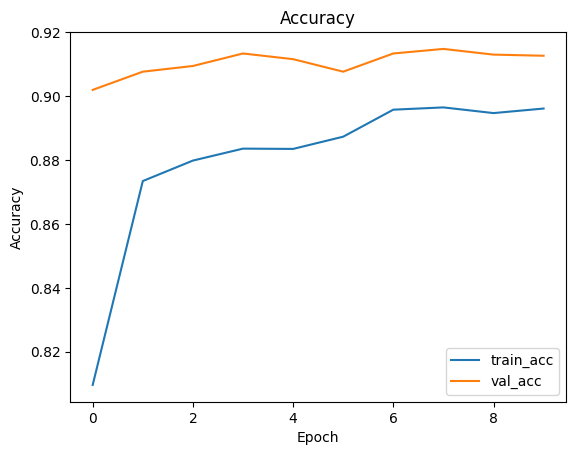

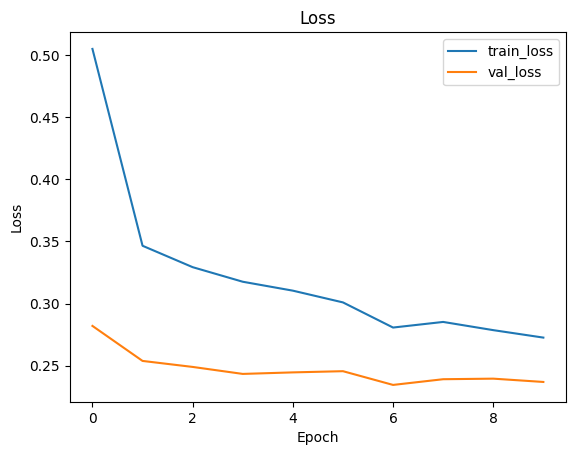

Kaydedildi: assets/baseline_accuracy.png & assets/baseline_loss.png


In [ ]:
import matplotlib.pyplot as plt, os
os.makedirs("assets", exist_ok=True)

def plot_and_save_history(h, prefix="run"):
    acc = h.history.get("accuracy", [])
    val_acc = h.history.get("val_accuracy", [])
    loss = h.history.get("loss", [])
    val_loss = h.history.get("val_loss", [])

    plt.figure()
    plt.plot(acc, label="train_acc"); plt.plot(val_acc, label="val_acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Accuracy")
    plt.savefig(f"assets/{prefix}_accuracy.png", dpi=150, bbox_inches="tight")
    plt.show()

    plt.figure()
    plt.plot(loss, label="train_loss"); plt.plot(val_loss, label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss")
    plt.savefig(f"assets/{prefix}_loss.png", dpi=150, bbox_inches="tight")
    plt.show()

plot_and_save_history(history, prefix="baseline")
print("Kaydedildi: assets/baseline_accuracy.png & assets/baseline_loss.png")



=== Classification Report ===
              precision    recall  f1-score   support

   buildings     0.9085    0.9314    0.9198       437
      forest     0.9895    0.9895    0.9895       474
     glacier     0.8673    0.8156    0.8406       553
    mountain     0.8647    0.8400    0.8522       525
         sea     0.8955    0.9745    0.9333       510
      street     0.9310    0.9162    0.9235       501

    accuracy                         0.9080      3000
   macro avg     0.9094    0.9112    0.9098      3000
weighted avg     0.9076    0.9080    0.9073      3000



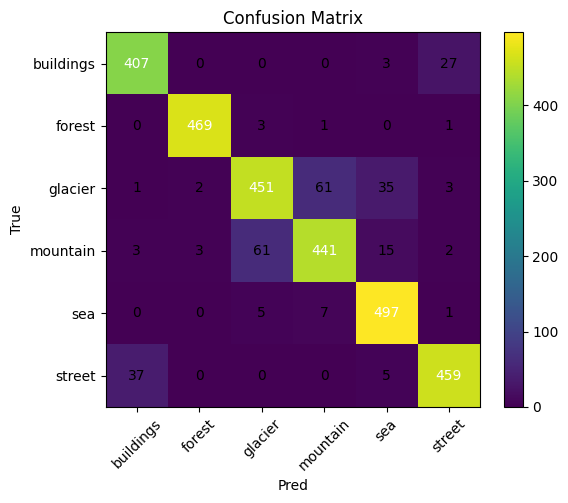

Kaydedildi: assets/confusion_matrix.png & assets/classification_report.txt


In [ ]:
import numpy as np, matplotlib.pyplot as plt, os
from sklearn.metrics import classification_report, confusion_matrix

# test_ds → tek dizi
test_images, test_labels = zip(*[(x.numpy(), y.numpy()) for x, y in test_ds.unbatch()])
test_images = np.stack(test_images)
test_labels = np.array(test_labels)

pred_probs = model.predict(test_images, batch_size=32, verbose=0)
preds = np.argmax(pred_probs, axis=1)

print("\n=== Classification Report ===")
report_str = classification_report(test_labels, preds, target_names=class_names, digits=4)
print(report_str)

# Raporu .txt olarak da kaydet
os.makedirs("assets", exist_ok=True)
with open("assets/classification_report.txt","w") as f:
    f.write(report_str)

# Confusion Matrix (göster + kaydet)
cm = confusion_matrix(test_labels, preds)
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix"); plt.colorbar()
ticks = np.arange(len(class_names))
plt.xticks(ticks, class_names, rotation=45); plt.yticks(ticks, class_names)
thr = cm.max()/2
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thr else "black")
plt.ylabel("True"); plt.xlabel("Pred"); plt.tight_layout()
plt.savefig("assets/confusion_matrix.png", dpi=150, bbox_inches="tight")
plt.show()

print("Kaydedildi: assets/confusion_matrix.png & assets/classification_report.txt")


Backbone: mobilenetv2_1.00_224 | Last conv: Conv_1
Pred: glacier | True: glacier


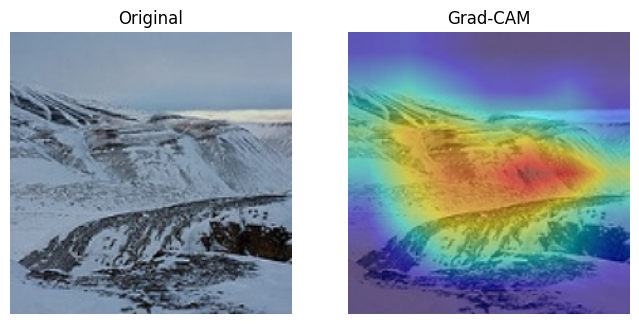

Saved: assets/gradcam_example.png


In [ ]:
# === GRAD-CAM (single-call tap inside backbone) ===
import os, random, numpy as np, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
try:
    import cv2
except:
    !pip -q install opencv-python-headless
    import cv2

# Modelden parçaları çek
backbone = model.get_layer("mobilenetv2_1.00_224")
gap_layer = model.get_layer("gap")
drop_layer = model.get_layer("drop")
clf_layer  = model.get_layer("classifier")
aug_layer  = model.get_layer("data_augmentation")

# Backbone içindeki son Conv2D katmanı
last_conv_name = [l.name for l in backbone.layers if isinstance(l, layers.Conv2D)][-1]
print("Backbone:", backbone.name, "| Last conv:", last_conv_name)

# Backbone'u TEK çağrıda hem (last conv) hem (backbone output) verecek alt-model
inner_tap = tf.keras.Model(
    inputs=backbone.input,
    outputs=[backbone.get_layer(last_conv_name).output, backbone.output]
)

# Tek grafik: inp -> preprocess -> aug(False) -> inner_tap -> (conv_maps, bb_out) -> gap->drop->clf
inp = model.input
x   = tf.keras.applications.mobilenet_v2.preprocess_input(inp)
x   = aug_layer(x, training=False)               # CAM için deterministic
conv_maps, bb_out = inner_tap(x, training=False)
logits = clf_layer(drop_layer(gap_layer(bb_out), training=False))
grad_model = tf.keras.Model(inputs=inp, outputs=[conv_maps, logits])

def make_gradcam_heatmap(img_array, class_index=None):
    img_array = tf.cast(img_array, tf.float32)
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_array, training=False)
        tape.watch(conv_out)                     # grad garanti
        if class_index is None:
            class_index = int(tf.argmax(preds[0]))
        score = preds[:, class_index]
        grads = tape.gradient(score, conv_out)

    if grads is None:
        raise RuntimeError("Gradients are None; check single-call wiring.")

    # Grad-CAM: kanal ağırlıkları (GAP of grads)
    weights = tf.reduce_mean(grads, axis=(1, 2))     # (1, C)
    conv    = conv_out[0]                            # (H, W, C)
    cam     = tf.tensordot(conv, weights[0], axes=(2, 0))  # (H, W)
    cam     = tf.maximum(cam, 0) / (tf.reduce_max(cam) + 1e-8)
    return cam.numpy()

def show_and_save_gradcam(img_any, heatmap, out_path="assets/gradcam_example.png", alpha=0.45):
    import numpy as np, os, cv2, matplotlib.pyplot as plt

    # --- helper: resmi uint8 RGB'ye çevir ---
    def to_uint8_rgb(x):
        arr = np.asarray(x)
        if arr.ndim == 2:                      # gri ise 3 kanala çıkar
            arr = np.stack([arr]*3, axis=-1)
        if arr.shape[-1] == 1:
            arr = np.repeat(arr, 3, axis=-1)
        if arr.dtype != np.uint8:
            # 0-1 aralığıysa 255'e ölçekle; değilse 0-255'e kırp
            maxv = float(arr.max()) if arr.size else 1.0
            if maxv <= 1.0:
                arr = (np.clip(arr, 0.0, 1.0) * 255.0).round().astype(np.uint8)
            else:
                arr = np.clip(arr, 0.0, 255.0).round().astype(np.uint8)
        return arr

    img_u8 = to_uint8_rgb(img_any)
    h, w = img_u8.shape[:2]

    # heatmap -> [0,255] uint8
    hm = cv2.resize(heatmap.astype(np.float32), (w, h))
    hm_norm = cv2.normalize(hm, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    hm_color = cv2.applyColorMap(hm_norm, cv2.COLORMAP_JET)   # BGR uint8

    # Her iki girdi de uint8 olduğundan addWeighted sorunsuz çalışır
    blended = cv2.addWeighted(img_u8, 1 - alpha, hm_color, alpha, 0)

    os.makedirs("assets", exist_ok=True)
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.imshow(img_u8); plt.axis("off"); plt.title("Original")
    plt.subplot(1,2,2); plt.imshow(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB)); plt.axis("off"); plt.title("Grad-CAM")
    plt.savefig(out_path, dpi=150, bbox_inches="tight"); plt.show()
    print("Saved:", out_path)


# Çalıştır (rastgele test görseli)
idx = random.randint(0, len(test_images)-1)
img = test_images[idx]
x_in = tf.image.resize(img[None, ...], (224, 224))
pred = model.predict(x_in, verbose=0)
print("Pred:", class_names[int(np.argmax(pred))], "| True:", class_names[int(test_labels[idx])])

hm = make_gradcam_heatmap(x_in)
show_and_save_gradcam(img, hm, out_path="assets/gradcam_example.png")


Epoch 1/3
351/351 ━━━━━━━━━━━━━━━━━━━━ 820s 2s/step - accuracy: 0.8982 - loss: 0.2835 - val_accuracy: 0.9081 - val_loss: 0.3663
Epoch 2/3
351/351 ━━━━━━━━━━━━━━━━━━━━ 860s 2s/step - accuracy: 0.9179 - loss: 0.2294 - val_accuracy: 0.9241 - val_loss: 0.2718
Epoch 3/3
351/351 ━━━━━━━━━━━━━━━━━━━━ 815s 2s/step - accuracy: 0.9263 - loss: 0.2017 - val_accuracy: 0.9259 - val_loss: 0.2701


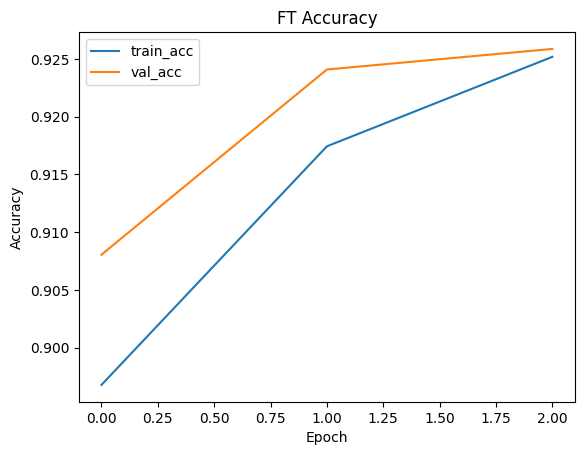

In [ ]:
# MobileNetV2 tabanını kademeli aç
base = model.get_layer("mobilenetv2_1.00_224")
base.trainable = True
# Alt katmanların çoğunu dondur, son ~20 katmanı eğit
for l in base.layers[:-20]:
    l.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

ft_history = model.fit(
    train_ds, validation_data=val_ds,
    epochs=3, callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
    ], verbose=1
)

# Fine-tune eğrilerini de kaydedelim
def plot_and_save_ft(h, prefix="finetune"):
    import matplotlib.pyplot as plt, os
    os.makedirs("assets", exist_ok=True)
    plt.figure(); plt.plot(h.history["accuracy"], label="train_acc")
    plt.plot(h.history["val_accuracy"], label="val_acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title("FT Accuracy")
    plt.savefig(f"assets/{prefix}_accuracy.png", dpi=150, bbox_inches="tight"); plt.show()

plot_and_save_ft(ft_history, "finetune")


In [ ]:
import numpy as np, math, matplotlib.pyplot as plt, tensorflow as tf, os

def to_uint8_rgb(arr):
    import numpy as np
    arr = np.asarray(arr)
    if arr.ndim == 2: arr = np.stack([arr]*3, axis=-1)
    if arr.shape[-1] == 1: arr = np.repeat(arr, 3, axis=-1)
    if arr.dtype in (np.float32, np.float64):
        if float(arr.max()) <= 1.0: arr = (np.clip(arr,0,1)*255).round().astype(np.uint8)
        else: arr = np.clip(arr,0,255).round().astype(np.uint8)
    elif arr.dtype != np.uint8:
        arr = np.clip(arr,0,255).astype(np.uint8)
    return arr

def show_sample_preds_clean(n=9, fname="assets/sample_preds.png", img_size=(224,224)):
    os.makedirs("assets", exist_ok=True)
    idxs = np.random.choice(len(test_images), size=min(n, len(test_images)), replace=False)
    cols=3; rows=math.ceil(len(idxs)/cols)
    plt.figure(figsize=(12, 4*rows))
    for i, idx in enumerate(idxs, 1):
        img = to_uint8_rgb(test_images[idx])
        x_in = tf.image.resize(img[None, ...], img_size)
        probs = model.predict(x_in, verbose=0)[0]
        pred = class_names[int(np.argmax(probs))]
        true = class_names[int(test_labels[idx])]
        ax = plt.subplot(rows, cols, i)
        ax.imshow(img); ax.set_axis_off()
        # 👇 başlığı alta yaz
        ax.text(0.5, -0.08, f"Pred: {pred}\nTrue: {true}",
                ha="center", va="top", transform=ax.transAxes, fontsize=10)
    plt.tight_layout()
    plt.savefig(fname, dpi=150, bbox_inches="tight")
    plt.show()
    print("Saved:", fname)

show_sample_preds_clean(25)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# === SAVE TO DRIVE (final) ===
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

DRIVE_PROJECT_DIR = "/content/drive/MyDrive/Colab Notebooks/zey akbank proje/intel-6scenes"
MODELS_DIR  = f"{DRIVE_PROJECT_DIR}/models"
ASSETS_DIR  = f"{DRIVE_PROJECT_DIR}/assets"
EXPORT_DIR  = f"{DRIVE_PROJECT_DIR}/export_artifacts"

import os, json, shutil, pickle
from tensorflow import keras
for d in [DRIVE_PROJECT_DIR, MODELS_DIR, ASSETS_DIR, EXPORT_DIR]:
    os.makedirs(d, exist_ok=True)

# model
keras_path = f"{MODELS_DIR}/intel_mnv2_final.keras"
model.save(keras_path)
print("Model ->", keras_path)

# (ops) h5
try:
    model.save(f"{MODELS_DIR}/intel_mnv2_final.h5")
except: pass

# sınıf adları + history
with open(f"{EXPORT_DIR}/class_names.json","w") as f: json.dump(class_names, f, ensure_ascii=False, indent=2)
try:
    with open(f"{EXPORT_DIR}/history.pkl","wb") as f: pickle.dump(history.history, f)
except: pass
try:
    with open(f"{EXPORT_DIR}/ft_history.pkl","wb") as f: pickle.dump(ft_history.history, f)
except: pass

# assets kopyala
if os.path.exists("assets"):
    for fname in os.listdir("assets"):
        src = os.path.join("assets", fname)
        dst = os.path.join(ASSETS_DIR, fname)
        if os.path.isfile(src): shutil.copy2(src, dst)
print("Assets ->", ASSETS_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Model -> /content/drive/MyDrive/Colab Notebooks/zey akbank proje/intel-6scenes/models/intel_mnv2_final.keras
Assets -> /content/drive/MyDrive/Colab Notebooks/zey akbank proje/intel-6scenes/assets
